<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#In-This-Notebook" data-toc-modified-id="In-This-Notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>In This Notebook</a></span></li><li><span><a href="#Pets" data-toc-modified-id="Pets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pets</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Pets-detector-(9-bboxes-max)" data-toc-modified-id="Pets-detector-(9-bboxes-max)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pets detector (9 bboxes max)</a></span></li></ul></li></ul></div>

# In This Notebook

**Context**

This notebook will take the single labeled bbox code and attempt multiple bounding boxes. I'll start with doing it just for one class (persons), then for persons and barn animals.

**To do:**
* 2020-10-21: use a Transform pad bboxes and lbls with zeros for n_obj < max_obj

**Log**

- 2020-10-27 (Tuesday): Broke off from _20201020_coco_multiple_bboxes_persons.ipynb.

**Thoughts/Notes:**
- 2020-10-26 (Mon):
    - I ordered bbox inputs (p1,p2,p3,c1,c2,c3,d1,d2,d3) s.t. p1 is larger than p2 and p2 is larger than p3. This does not appear to have worked, even with the pets dataset I created.
    - Person bboxer's dls.train.n → 15701. Pet bboxer's dls.train.n → 6778. Harder task + fewer training samples = worse results. However, the learner doesn't appear to be learning the task at all. The results do not make sense.
- 2020-10-27 (Tues): I believe my best bet is to stick to 2018.9 to get over this hump.

In [ ]:
### Unused Helpers ###
# flatten L or list
def flatten(l):
    def _recur(l,res):
        for o in l:
            if isinstance(o,L): _recur(o,res)
            if isinstance(o,list): _recur(o,res)
            else: res.append(o)
        return res
    return _recur(l,L())    

# Pets

## Data

In [ ]:
from fastai.vision.all import *

### 40sec ###


### Get files and annos ###
# paths to data
path = Path('/home/rory/data/coco2017')
train_im_dir, valid_im_dir = 'train2017', 'val2017'
train_json = 'annotations/instances_train2017.json'
valid_json = 'annotations/instances_val2017.json'
# create lists of items
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_files, train_annos = get_annos(path, train_json, train_im_dir)
valid_files, valid_annos = get_annos(path, valid_json, valid_im_dir)
files  = train_files + valid_files
annos  = train_annos + valid_annos
bboxes = [a[0] for a in annos]
lbls   = [a[1] for a in annos]
# create helper cols
is_valid = [0]*len(train_files) + [1]*len(valid_files)
n_items  = L(len(l) for l in lbls)


### Create subsets for task ###
def transpose(anno): return list(zip(*anno)) # tensor.t()
def bbox_area(transposed_anno):
    b = transposed_anno[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos  = L(sort_annos(i) for i in annos)
sorted_bboxes = L(L(o[0] for o in a) for a in sorted_annos)
sorted_lbls   = L(L(o[1] for o in a) for a in sorted_annos)
# persons
per_idxs   = L(L(o=='person' for o in lbl) for lbl in sorted_lbls)
per_lbls   = L(o[i] for o,i in zip(sorted_lbls,  per_idxs))
per_bboxes = L(o[i] for o,i in zip(sorted_bboxes,per_idxs))
# persons
cat_idxs   = L(L(o=='cat' for o in lbl) for lbl in sorted_lbls)
cat_lbls   = L(o[i] for o,i in zip(sorted_lbls,  cat_idxs))
cat_bboxes = L(o[i] for o,i in zip(sorted_bboxes,cat_idxs))
# persons
dog_idxs   = L(L(o=='dog' for o in lbl) for lbl in sorted_lbls)
dog_lbls   = L(o[i] for o,i in zip(sorted_lbls,  dog_idxs))
dog_bboxes = L(o[i] for o,i in zip(sorted_bboxes,dog_idxs))

# count instances of each class
def count_instances(lbl, lol): return L(sum([o==lbl for o in l]) for l in lol)
n_pers = count_instances('person', sorted_lbls)
n_cats = count_instances('cat',    sorted_lbls)
n_dogs = count_instances('dog',    sorted_lbls)


### Store outputs in a pickle ###
df = pd.DataFrame({
    # basics
    "path": files,
    "per_lbls": per_lbls,
    "cat_lbls": cat_lbls,
    "dog_lbls": dog_lbls,
    "per_bboxes": per_bboxes,
    "cat_bboxes": cat_bboxes,
    "dog_bboxes": dog_bboxes,
    "n_pers": n_pers,
    "n_cats": n_cats,
    "n_dogs": n_dogs,
    })
df.to_pickle(path/'20201020_coco_multiple_bboxes_pets_df.pkl')

/home/rory/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1223: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(v, copy=False)
/home/rory/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1615: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subarr = np.array(values, dtype=dtype, copy=copy)


## Pets detector (9 bboxes max)

In [ ]:
from fastai.vision.all import *
from IPython.display import Markdown, display


### Params ###
im_size     = 224
batch_size  = 64
path        = Path('/home/rory/data/coco2017')
valid_pct   = .15
    

### Data ###
df = pd.read_pickle(path/'20201020_coco_multiple_bboxes_pets_df.pkl')
df['n_pets'] = df.n_pers + df.n_cats + df.n_dogs

In [ ]:
df_pets = df.query('n_pers <= 3').query('n_cats <= 3').query('n_dogs <= 3')
df_cats = df_pets.query('n_pets <= 9').query('n_cats in [1,2,3]')
df_dogs = df_pets.query('n_pets <= 9').query('n_dogs in [1,2,3]')
df_pets = pd.concat([df_cats, df_dogs]).reset_index().drop_duplicates('index')

In [ ]:
### Items ###
def get_col(df,col): return L(df[col].to_list())
paths      = get_col(df_pets,'path')
per_lbls   = get_col(df_pets,'per_lbls')
cat_lbls   = get_col(df_pets,'cat_lbls')
dog_lbls   = get_col(df_pets,'dog_lbls')
per_bboxes = get_col(df_pets,'per_bboxes')
cat_bboxes = get_col(df_pets,'cat_bboxes')
dog_bboxes = get_col(df_pets,'dog_bboxes')
n_pers     = get_col(df_pets,'n_pers')
n_cats     = get_col(df_pets,'n_cats')
n_dogs     = get_col(df_pets,'n_dogs')

plbls = [l + (3-n)*['x'] for l,n in zip(per_lbls,n_pers)]
clbls = [l + (3-n)*['x'] for l,n in zip(cat_lbls,n_cats)]
dlbls = [l + (3-n)*['x'] for l,n in zip(dog_lbls,n_dogs)]
path2lbl = {pth: p+c+d for pth,p,c,d in zip(paths,plbls,clbls,dlbls)}
def get_lbl(p): return path2lbl[p]

pbbs = [b + (3-n)*[[0,0,0,0]] for b,n in zip(per_bboxes,n_pers)]
cbbs = [b + (3-n)*[[0,0,0,0]] for b,n in zip(cat_bboxes,n_cats)]
dbbs = [b + (3-n)*[[0,0,0,0]] for b,n in zip(dog_bboxes,n_dogs)]
path2bbox = {pth: p+c+d for pth,p,c,d in zip(paths,pbbs,cbbs,dbbs)}
def get_bbox(p): return path2bbox[p]

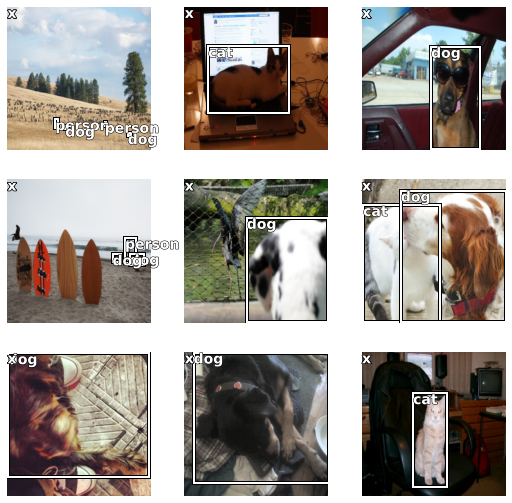

In [ ]:
### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(im_size, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    n_inp=1)
dls = db.dataloaders(paths)
dls.show_batch() # dls.train.n = 6778

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


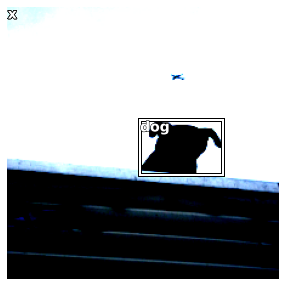

In [ ]:
b = dls.one_batch()
b[0].shape, b[1].shape, b[2].shape

bbs_dec  = TensorBBox((b[1][0]+1)*224//2)
lbls_dec = dls.vocab[list(np.array(b[2][0].cpu()))]
lbbs_dec = LabeledBBox(bbs_dec, lbls_dec)

ctx = show_image(b[0][0]);
lbbs_dec.show(ctx=ctx);

In [ ]:
### Model ###
class custom_module(Module):
    
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))
body = create_body(resnet34, pretrained=True)
max_bbs  = 9
bb_acts  = max_bbs*4
lbl_acts = max_bbs
head = create_head(1024, bb_acts+lbl_acts, ps=0.5)
mod  = custom_module(body, head)


### Loss ###
def mse(f, bb, lbl): return MSELossFlat()(f[:,:bb_acts], bb)

lr_min: 0.002754228748381138


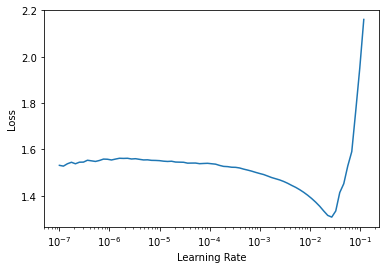

In [ ]:
### Training ###
learner = Learner(dls, mod, loss_func=mse)
lr_min, _ = learner.lr_find(); print("lr_min:", lr_min)

In [ ]:
learner.fit_one_cycle(10, lr=lr_min) # 0.137628

epoch,train_loss,valid_loss,time
0,1.280115,0.855244,00:15
1,0.764047,0.438514,00:16
2,0.378514,0.181193,00:16
3,0.275588,0.211247,00:15
4,0.236953,0.185027,00:15
5,0.220807,0.155529,00:16
6,0.203355,0.144044,00:15
7,0.186612,0.140873,00:16
8,0.178256,0.139132,00:16
9,0.173884,0.137628,00:16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

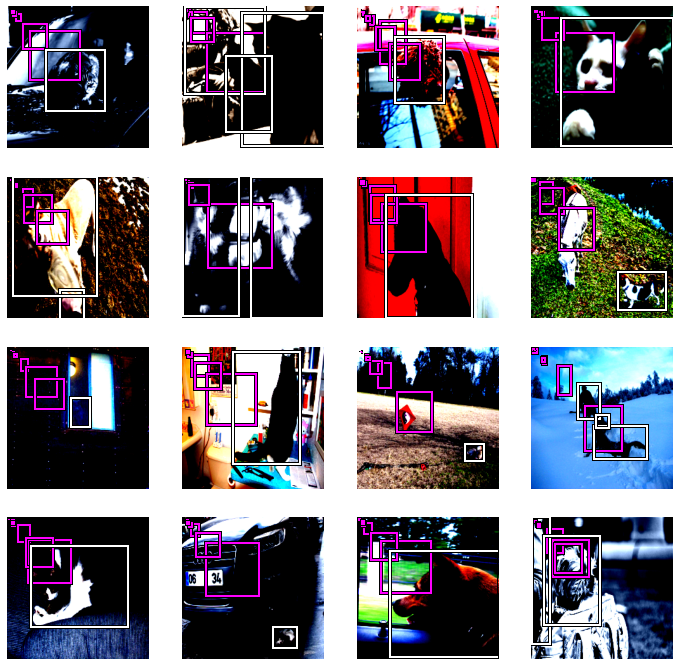

In [ ]:
def view_mbb_results(learner, n=16, nrows=4, ncols=4, offset=0):
    # get batch of ims & targs, get preds
    ims, targ_bbs, targ_lbls = learner.dls.one_batch()
    preds = learner.model(ims)
    pred_bbs, pred_lbls = preds[:,:bb_acts], preds[:,bb_acts:].argmax(dim=-1)
    decoded_ims = ims

    # show grid results
    for i,ctx in enumerate(get_grid(n, nrows, ncols)):
        idx = i+offset*n
        # title
    #     pred_cls = dls.vocab[pred_lbls[idx].item()]
    #     targ_cls = dls.vocab[targ_lbls[idx].item()]
    #     icon = '✔️' if pred_cls==targ_cls else '✖️'
    #     title = f"{icon}  P {pred_cls} : A {targ_cls}"
        # im
        show_image(decoded_ims[idx], ctx=ctx)#, title=title)
        # bbs
        pred_bb = TensorBBox(pred_bbs[idx])
        targ_bb = TensorBBox(targ_bbs[idx])
        ((pred_bb+1)*224//2).show(ctx=ctx, color='magenta')
        ((targ_bb+1)*224//2).show(ctx=ctx); 
view_mbb_results(learner)

In [ ]:

def cel(f, bb, lbl): return CrossEntropyLossFlat()(f[:,4:], lbl)
def lbb_loss(f, bb, lbl): return 5*mse(f,bb,lbl) + cel(f,bb,lbl)
def acc(f, bb, lbl): return accuracy(f[:,4:], lbl)